# **Atmosphere Sanity Check**

## *Imports*

Need to import wrf-python, cartopy, and netcdf in order to properly plot pressure, winds.

In [1]:
import wrf
from netCDF4 import Dataset #type: ignore
import numpy as np
import cartopy.crs as crs
import matplotlib.pyplot as plt
from cartopy.feature import NaturalEarthFeature
from matplotlib.cm import get_cmap

In [2]:
wrffile = Dataset('2023/wrfout/wrfout_d01_2023-07-21_18:00:00')

z = wrf.getvar(wrffile, 'z', units='m')
p = wrf.getvar(wrffile, 'pressure')
ua = wrf.getvar(wrffile, 'ua', units='kt')
va = wrf.getvar(wrffile, 'va', units='kt')
t2 = wrf.getvar(wrffile, 'T2') - 273.15 # K -> deg C


In [3]:
u_10 = wrf.interplevel(ua, z, 10)
v_10 = wrf.interplevel(va, z, 10)
p_10 = wrf.interplevel(p, z, 10)

In [4]:
lats, lons = wrf.latlon_coords(p_10)
cart_proj = wrf.get_cartopy(p_10)

In [5]:
import cartopy
cartopy.config['data_dir']

PosixPath('/home1/07655/tg869546/.local/share/cartopy')

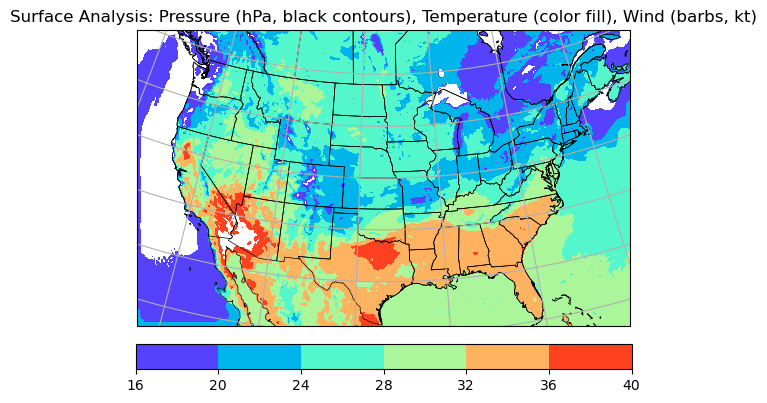

In [6]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection': cart_proj})

states = NaturalEarthFeature(category='cultural',scale='50m',facecolor='none',name='admin_1_states_provinces')
ax.add_feature(states, linewidth=0.5, edgecolor='black')
ax.coastlines('50m', linewidth=0.5)


levels = np.arange(1004., 1024., 4.)
contours = plt.contour(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(p_10), levels=levels, colors='black', transform=crs.PlateCarree())

t_levels = np.arange(16., 42., 4.)
t_contours = plt.contourf(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(t2), levels=t_levels, cmap=plt.get_cmap('rainbow'), transform=crs.PlateCarree())
plt.colorbar(t_contours, ax=ax, orientation='horizontal', pad=0.05)

plt.barbs(wrf.to_np(lons[::125, ::125]), wrf.to_np(lats[::125, ::125]), wrf.to_np(u_10[::125, ::125]), wrf.to_np(v_10[::125, ::125]), length=6, transform=crs.PlateCarree())

ax.set_xlim(wrf.cartopy_xlim(p_10))
ax.set_ylim(wrf.cartopy_ylim(p_10))

ax.gridlines()

plt.title('Surface Analysis: Pressure (hPa, black contours), Temperature (color fill), Wind (barbs, kt)')
plt.savefig('sfc-2023-07-21_18z.png')
plt.show()